In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from distfit import distfit
import re
from sympy import symbols, simplify, sin, cos, log, Abs, exp, expand_power_base, Mul, Rational, sqrt
from sympy.parsing.sympy_parser import parse_expr
import seaborn as sns
import copy
import json
from ydata_profiling import ProfileReport
import sys
import os
import bnlearn as bn
os.environ["JULIA_NUM_THREADS"] = "8"

# Add the directory containing 'thesis_utils.py' to the system path
sys.path.append(os.path.abspath('..'))  # If 'thesis_utils.py' is one level up
# Or use this if it's in the same directory as the notebook:
# sys.path.append(os.getcwd())

from thesis_utils import *

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [43]:
import importlib
import thesis_utils  # or whatever your module is called

importlib.reload(thesis_utils)

from thesis_utils import *

In [3]:
data = pd.read_csv('C:/Users/svenl/vs_code_projects/hyperRealDataDescriber/data/credit_score/cleaned_credit_score_v2.csv')
data = data.drop(['ID', 'Customer_ID', 'Name', 'SSN', 'Type_of_Loan', 'Payment_Behaviour'], axis=1)
data, rename_map = anonymize_column_names(data)

In [4]:
# Generate the profiling report
profile = ProfileReport(data, title="Credit Score Cleaned and Anonymized", explorative=True)

# Get the description object
desc = profile.get_description()

# Access the correlation matrix
correlation_matrix = desc.correlations["auto"]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
categorical_cols = get_categorical_columns(data)

In [6]:
distributions = fit_distributions(data)

In [7]:
marginals = convert_distfit_to_marginals(distributions, data)

In [8]:
data_syn = generate_synthetic_dataset(original_data=data, correlation_matrix=correlation_matrix, categorical_columns=categorical_cols, marginals=marginals, n_rows=37000, correlation_threshold=0.1)

In [ ]:
data_syn_export = deanonymize_column_names(data_syn, rename_map)
data_syn_export.to_csv('C:/Users/svenl/vs_code_projects/hyperRealDataDescriber/data/credit_score/cleaned_credit_score_v2_copula_syn.csv')

In [9]:
# Generate the profiling report
profile_syn = ProfileReport(data_syn, title="Credit Score Cleaned and Anonymized SYN", explorative=True)

# Get the description object
desc_syn = profile_syn.get_description()

# Access the correlation matrix
correlation_matrix_syn = desc_syn.correlations["auto"]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [22]:
from sdmetrics.reports.single_table import QualityReport
from sdmetrics.single_table import NewRowSynthesis

metadata = {
    "columns": {
        "X1": {"sdtype": "categorical"},
        "X2": {"sdtype": "numerical"},
        "X3": {"sdtype": "categorical"},
        "X4": {"sdtype": "numerical"},
        "X5": {"sdtype": "numerical"},
        "X6": {"sdtype": "numerical"},
        "X7": {"sdtype": "numerical"},
        "X8": {"sdtype": "numerical"},
        "X9": {"sdtype": "numerical"},
        "X10": {"sdtype": "numerical"},
        "X11": {"sdtype": "numerical"},
        "X12": {"sdtype": "numerical"},
        "X13": {"sdtype": "numerical"},
        "X14": {"sdtype": "categorical"},
        "X15": {"sdtype": "numerical"},
        "X16": {"sdtype": "numerical"},
        "X17": {"sdtype": "numerical"},
        "X18": {"sdtype": "categorical"},
        "X19": {"sdtype": "numerical"},
        "X20": {"sdtype": "numerical"},
        "X21": {"sdtype": "numerical"},
    }
}

report = QualityReport()
report.generate(data, data_syn, metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 21/21 [00:00<00:00, 47.54it/s]|
Column Shapes Score: 94.94%

(2/2) Evaluating Column Pair Trends: |██████████| 210/210 [00:01<00:00, 126.00it/s]|
Column Pair Trends Score: 91.11%

Overall Score (Average): 93.02%



In [11]:
plot_correlation_matrices(correlation_matrix, correlation_matrix_syn, "Real", "Synthetic")

In [12]:
expression_str_raw = "(0.49049717 * (((x3 * 0.7884265) + x2) - ((x0 - (x1 - (0.49049717 - (sqrt(x5) - ((cos(x5) - x4) / 0.44592214))))) * 0.17963816))) + 2.411056"
num_independent_vars = 6

def generate_var_string(num_independent_vars):
    var_string = ''
    for i in range(num_independent_vars):
        var_string = var_string + ('x' + str(i) + ' ')
    return var_string[0:len(var_string) - 1]

variables = generate_var_string(num_independent_vars)

exec(f"{', '.join(variables.split())} = symbols('{variables}')")

parsed_expr = parse_expr(expression_str_raw)
expr = simplify(parsed_expr)
print(expr)

-0.0881120091040072*x0 + 0.0881120091040072*x1 + 0.49049717*x2 + 0.386720967003005*x3 + 0.197595053486259*x4 + 0.0881120091040072*sqrt(x5) - 0.197595053486259*cos(x5) + 2.36783730889147


In [12]:
# define variables to use in expression
x0_ = data_syn['X8'].to_numpy()  # 'Credit_History_Age'
x1_ = data_syn['X10'].to_numpy()  # 'Delay_from_due_date'
x2_ = data_syn['X6'].to_numpy()  # 'Num_Bank_Accounts'
x3_ = data_syn['X13'].to_numpy()  # 'Num_Credit_Inquiries'
x4_ = data_syn['X11'].to_numpy()  # 'Num_of_Delayed_Payment'
x5_ = data_syn['X15'].to_numpy()  # 'Outstanding_Debt'

X8_predicted = -0.0881120091040072*x0_ + 0.0881120091040072*x1_ + 0.49049717*x2_ + 0.386720967003005*x3_ + 0.197595053486259*x4_ + 0.0881120091040072*np.sqrt(x5_) - 0.197595053486259*np.cos(x5_) + 2.36783730889147

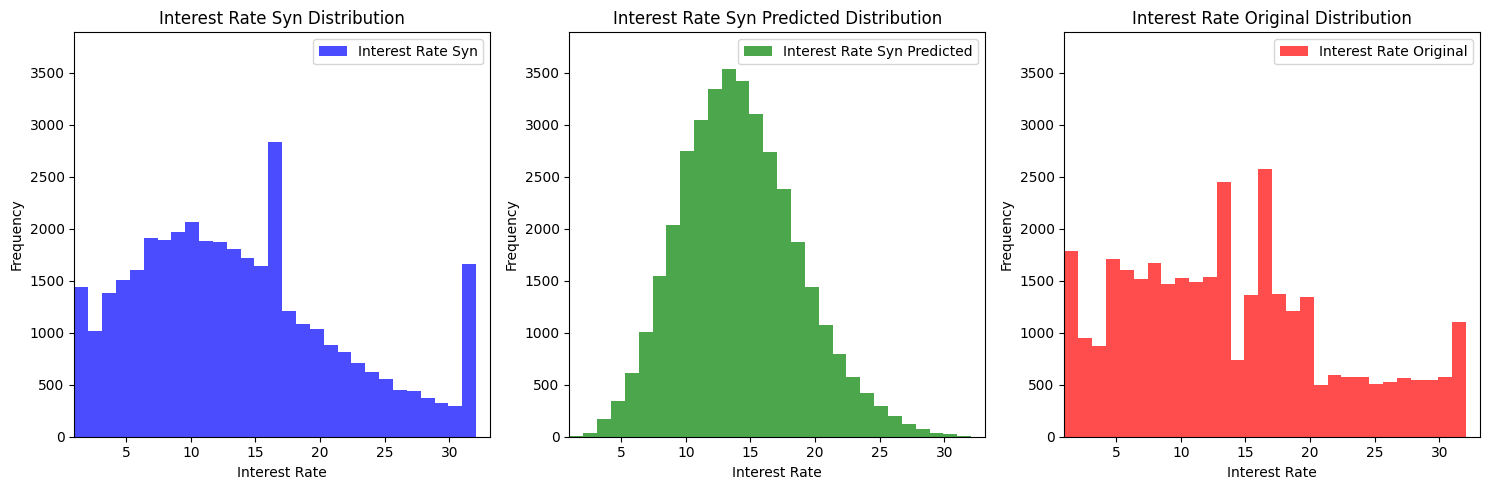

In [13]:
%matplotlib inline
plot_histograms([(data_syn["X8"], "Interest Rate Syn", "blue"), (X8_predicted, "Interest Rate Syn Predicted", "green"), (data["X8"], "Interest Rate Original", "red")], xlabel="Interest Rate")

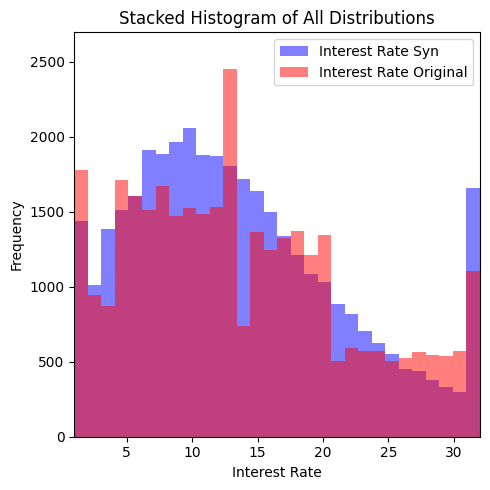

In [14]:
%matplotlib inline
plot_histograms([(data_syn["X8"], "Interest Rate Syn", "blue"), (data["X8"], "Interest Rate Original", "red")], xlabel="Interest Rate", stack=True)

In [15]:
X8_corrected = correct_sr_inference(data_syn, ["X10", "X6", "X13", "X11", "X15"], "X8", pd.Series(X8_predicted))

XGBoost Residual Correction Test MSE: 5.0828
Final MSE after XGBoost residual correction: 1.0431


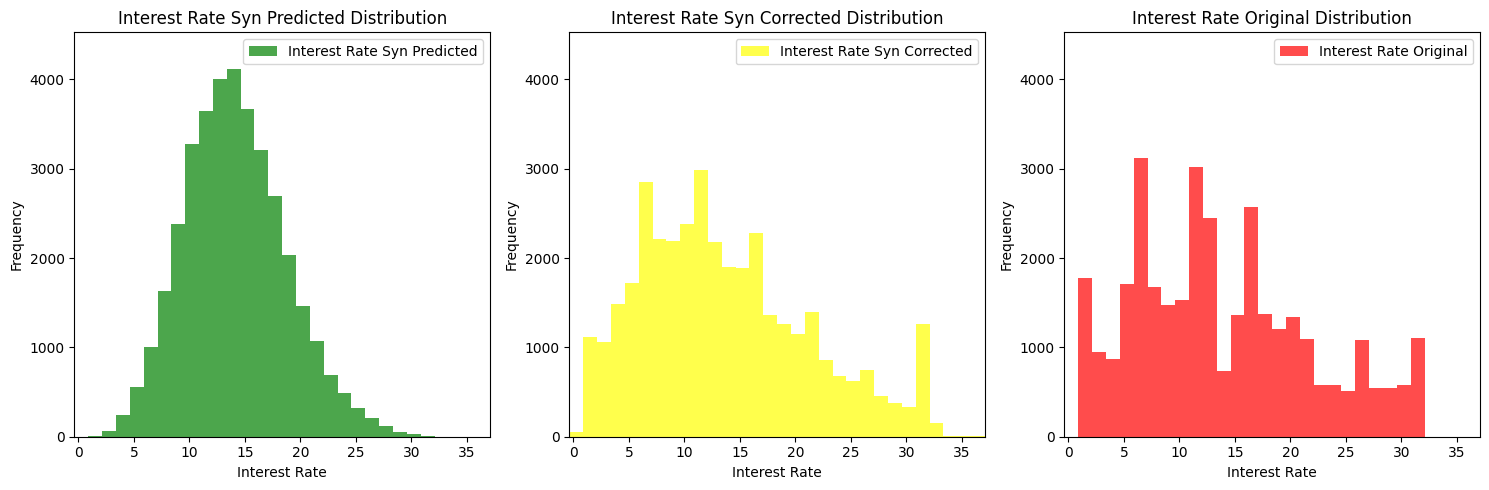

In [16]:
%matplotlib inline
plot_histograms([(X8_predicted, "Interest Rate Syn Predicted", "green"), (X8_corrected, "Interest Rate Syn Corrected", "yellow"),(data["X8"], "Interest Rate Original", "red")], xlabel="Interest Rate")

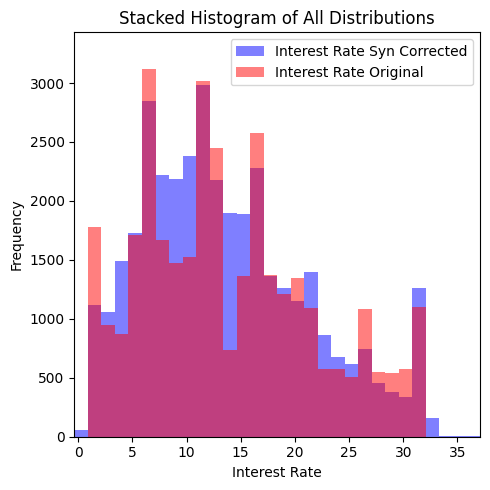

In [17]:
%matplotlib inline
plot_histograms([(X8_corrected, "Interest Rate Syn Corrected", "blue"), (data["X8"], "Interest Rate Original", "red")], xlabel="Interest Rate", stack=True)

In [18]:
data_syn["X8"] = X8_corrected

In [19]:
# Generate the profiling report
profile_syn_sr = ProfileReport(data_syn, title="Credit Score Cleaned and Anonymized SYN SR", explorative=True)

# Get the description object
desc_syn_sr = profile_syn_sr.get_description()

# Access the correlation matrix
correlation_matrix_syn_sr = desc_syn_sr.correlations["auto"]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [20]:
plot_correlation_matrices(correlation_matrix, correlation_matrix_syn_sr, "Real", "Synthetic SR")

<Figure size 640x480 with 0 Axes>

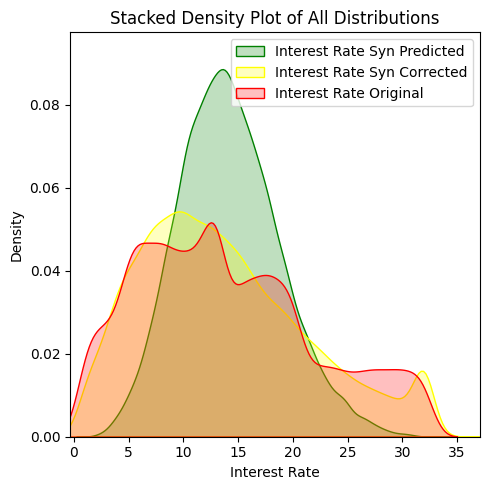

In [21]:
%matplotlib inline
plot_densities([(X8_predicted, "Interest Rate Syn Predicted", "green"), (X8_corrected, "Interest Rate Syn Corrected", "yellow"),(data["X8"], "Interest Rate Original", "red")], xlabel="Interest Rate", stack=True)